In [10]:
import pickle

with open('results/data/chaos_with_input_rates_session_1.pkl', 'rb') as file:
    data = pickle.load(file)

In [14]:
len(data)

1153

In [16]:
400*3

1200

In [19]:
import pickle
with open('results/data/chaos_with_input_rates_session_1.pkl', 'rb') as f:
    results = pickle.load(f)

# Check which combinations you have
import numpy as np
v_th_values = sorted(set(r['v_th_std'] for r in results))
g_values = sorted(set(r['g_std'] for r in results))  
input_rates = sorted(set(r['static_input_rate'] for r in results))

print(f"v_th values: {len(v_th_values)} (expected 20)")
print(f"g values: {len(g_values)} (expected 20)")
print(f"input rates: {len(input_rates)} (expected 3)")
print(f"Total combinations: {len(results)} (expected {len(v_th_values) * len(g_values) * len(input_rates)})")

# Check for missing combinations
expected_combinations = set()
for v in v_th_values:
    for g in g_values:
        for r in input_rates:
            expected_combinations.add((v, g, r))

actual_combinations = set((r['v_th_std'], r['g_std'], r['static_input_rate']) for r in results)
missing = expected_combinations - actual_combinations
print(f"Missing {len(missing)} combinations")

v_th values: 20 (expected 20)
g values: 20 (expected 20)
input rates: 3 (expected 3)
Total combinations: 1153 (expected 1200)
Missing 47 combinations


In [12]:
import numpy as np

g_std_list = sorted({entry['g_std'] for entry in data})
v_th_std_list = sorted({entry['v_th_std'] for entry in data}, reverse=True)  # descending y-axis

lz_matrix = np.zeros((len(v_th_std_list), len(g_std_list)))
hamming_matrix = np.zeros((len(v_th_std_list), len(g_std_list)))

for i, v_th in enumerate(v_th_std_list):
    for j, g_std in enumerate(g_std_list):
        for entry in data:
            if entry['g_std'] == g_std and entry['v_th_std'] == v_th:
                lz_matrix[i, j] = entry['lz_mean']
                hamming_matrix[i, j] = entry['hamming_mean']
                break

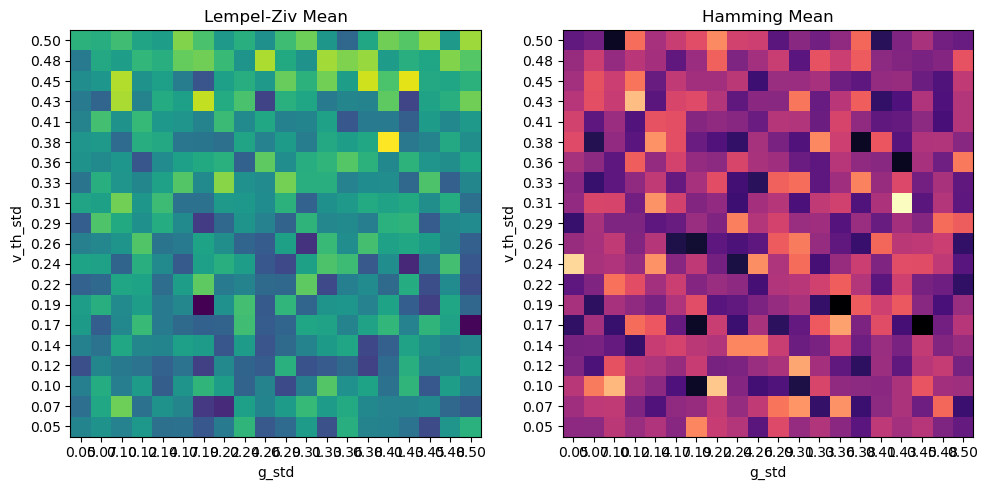

In [13]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

# Plot lz_mean heatmap
im1 = axarr[0].imshow(lz_matrix, aspect='auto', cmap='viridis', origin='upper')
axarr[0].set_title('Lempel-Ziv Mean')
axarr[0].set_xlabel('g_std')
axarr[0].set_ylabel('v_th_std')
axarr[0].set_xticks(np.arange(len(g_std_list)))
axarr[0].set_xticklabels([f'{g:.2f}' for g in g_std_list])
axarr[0].set_yticks(np.arange(len(v_th_std_list)))
axarr[0].set_yticklabels([f'{v:.2f}' for v in v_th_std_list])

# Plot hamming_mean heatmap
im2 = axarr[1].imshow(hamming_matrix, aspect='auto', cmap='magma', origin='upper')
axarr[1].set_title('Hamming Mean')
axarr[1].set_xlabel('g_std')
axarr[1].set_ylabel('v_th_std')
axarr[1].set_xticks(np.arange(len(g_std_list)))
axarr[1].set_xticklabels([f'{g:.2f}' for g in g_std_list])
axarr[1].set_yticks(np.arange(len(v_th_std_list)))
axarr[1].set_yticklabels([f'{v:.2f}' for v in v_th_std_list])

plt.tight_layout()
plt.show()


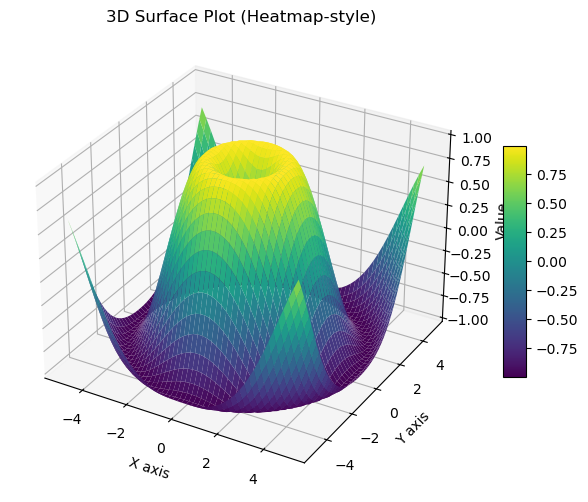

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_title('3D Surface Plot (Heatmap-style)')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Value')

plt.show()


In [22]:
def gamma_coincidence(spike_train1, spike_train2, window=0.005):
    spike_train1 = sorted(spike_train1)
    spike_train2 = sorted(spike_train2)
    
    count_coincidences = 0
    i, j = 0, 0
    
    while i < len(spike_train1) and j < len(spike_train2):
        dt = spike_train1[i] - spike_train2[j]
        if abs(dt) <= window:
            count_coincidences += 1
            i += 1
            j += 1
        elif dt < 0:
            i += 1
        else:
            j += 1
    
    norm = (len(spike_train1) + len(spike_train2)) / 2
    if norm == 0:
        return 0
    return count_coincidences / norm


def average_gamma_coincidence(network1, network2, window=0.005):
    """
    Compute average normalized gamma coincidence between two networks.
    
    Args:
        network1: list of tuples (neuron_id, spike_time)
        network2: list of tuples (neuron_id, spike_time)
        window: coincidence time window (seconds)
    
    Returns:
        Average normalized gamma coincidence across corresponding neurons.
    """
    from collections import defaultdict
    
    # Organize spike trains by neuron_id
    spikes_net1 = defaultdict(list)
    spikes_net2 = defaultdict(list)
    
    for neuron_id, spike_time in network1:
        spikes_net1[neuron_id].append(spike_time)
    for neuron_id, spike_time in network2:
        spikes_net2[neuron_id].append(spike_time)
    
    neuron_ids = set(spikes_net1.keys()) & set(spikes_net2.keys())
    if not neuron_ids:
        return None  # No overlapping neurons
    
    coincidences = []
    for neuron_id in neuron_ids:
        c = gamma_coincidence(spikes_net1[neuron_id], spikes_net2[neuron_id], window=window)
        coincidences.append(c)
    
    return sum(coincidences) / len(coincidences)




In [27]:
# Example usage:
network1 = [
    (1, 0.01), (1, 0.02), (1, 0.03),
    (2, 0.05), (2, 0.10),
    (3, 0.07), (3, 0.08)
]

network2 = [
    (1, 0.015), (1, 0.025),
    (2, 0.055), (2, 0.12),
    (3, 0.09), (3, 0.10)
]

avg_gamma = average_gamma_coincidence(network1, network2, window=0.005)
print(f"Average gamma coincidence across neurons: {avg_gamma:.3f}")


Average gamma coincidence across neurons: 0.433


In [30]:
# Example usage:
network1 = [
    (1, 0.01), (1, 0.02), (1, 0.03),
    (2, 0.05), (2, 0.10),
    (3, 0.07), (3, 0.08)
]

network2 = [
    (1, 0.015), (1, 0.025),
    (2, 0.055), (2, 0.12),
    (3, 0.07), (3, 0.10), (3, 0.30)
]

avg_gamma = average_gamma_coincidence(network1, network2, window=0.005)
print(f"Average gamma coincidence across neurons: {avg_gamma:.3f}")


Average gamma coincidence across neurons: 0.567
